In [170]:
import os
import pandas
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [171]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        label = self._load_label(label_path)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    
    # Helper function to get label from images
    def _load_label(self, label_path):
        # parse the label path and read files
        with open(label_path, 'r') as file:
            boxes = []
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                boxes.append([class_id, x_center, y_center, width, height])
        return torch.tensor(boxes)

In [172]:
# Variable Length Data: Each image can have a different number of bounding boxes. 
# The default collate_fn tries to stack everything into tensors, which fails if they have different shapes.

# Stack images into tensors but not targets to avoid this conflict
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])
    images = torch.stack(images, dim=0)
    return images, targets

In [173]:
# class IDs
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [174]:
train_labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
train_img_dir = "../data/VehiclesDetectionDataset/train/images/"
test_labels_dir = "../data/VehiclesDetectionDataset/test/labels/"
test_img_dir = "../data/VehiclesDetectionDataset/test/images/"

In [175]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# load images dataset
trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [176]:
# Calculate mean and std of image dataset
sum_ = torch.zeros(3)
sum_squared = torch.zeros(3)
num_images = 0

for images, _ in trainloader:
    sum_ += images.sum(dim=[0, 2, 3])
    sum_squared += (images ** 2).sum(dim=[0, 2, 3])
    num_images += images.size(0)

mean = sum_ / (num_images * images.size(2) * images.size(3))
std = (sum_squared / (num_images * images.size(2) * images.size(3)) - mean ** 2).sqrt()

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4525, 0.4424, 0.4260])
Std: tensor([0.2787, 0.2777, 0.2892])


In [177]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [178]:
norm_trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
norm_trainloader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [179]:
testset = DetectDataset(test_labels_dir, test_img_dir, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [180]:
train_features, train_labels = next(iter(trainloader))

In [181]:
train_features

tensor([[[[0.9765, 0.9882, 0.9725,  ..., 0.9412, 0.9373, 0.9373],
          [0.9373, 0.9412, 0.9490,  ..., 0.8667, 0.8549, 0.8627],
          [0.9647, 0.9294, 0.9255,  ..., 0.9725, 0.9569, 0.9686],
          ...,
          [0.2667, 0.2627, 0.2510,  ..., 0.3725, 0.3608, 0.3529],
          [0.2745, 0.2667, 0.2510,  ..., 0.3412, 0.3529, 0.3608],
          [0.2745, 0.2627, 0.2431,  ..., 0.2863, 0.3216, 0.3490]],

         [[0.7098, 0.7216, 0.7137,  ..., 0.7765, 0.7882, 0.8078],
          [0.6941, 0.6980, 0.7059,  ..., 0.6941, 0.7059, 0.7216],
          [0.7569, 0.7333, 0.7294,  ..., 0.7843, 0.7922, 0.8118],
          ...,
          [0.2941, 0.2902, 0.2784,  ..., 0.4000, 0.3882, 0.3804],
          [0.3020, 0.2941, 0.2784,  ..., 0.3686, 0.3804, 0.3882],
          [0.3020, 0.2902, 0.2706,  ..., 0.3137, 0.3490, 0.3765]],

         [[0.6588, 0.6706, 0.6588,  ..., 0.5882, 0.5961, 0.6078],
          [0.6510, 0.6549, 0.6627,  ..., 0.5098, 0.5137, 0.5255],
          [0.7255, 0.6980, 0.6941,  ..., 0

In [182]:
train_labels[0][0]

tensor([2.0000, 0.6803, 0.2464, 0.1875, 0.1046])

Class ID: tensor([2.0000, 0.6803, 0.2464, 0.1875, 0.1046])
Box Coordinates: 2.0
Box Coordinates: 0.6802884340286255
Box Coordinates: 0.24639423191547394
Box Coordinates: 0.1875
Box Coordinates: 0.10456730425357819
torch.Size([416, 416, 3])


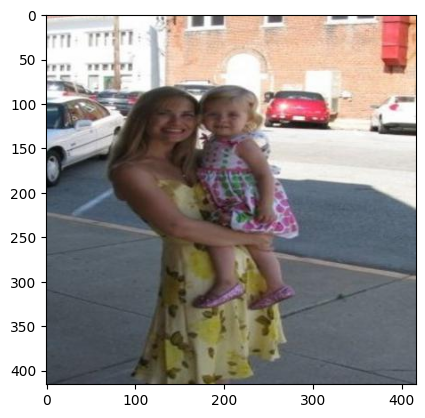

In [183]:
print(f"Class ID: {train_labels[0][0]}")
for box in train_labels[0][0]: print(f"Box Coordinates: {box}")
img = train_features[0]
img = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()

In [184]:
# Convert tensor image to correct openCV image format
def tensor_to_cv2_image(tensor):
    # Convert GPU tensor to CPU based
    image = tensor.cpu().numpy() 
    image = (image * 255) # convert to unnormalized pixel values
    image = np.ascontiguousarray(image, np.uint8)
    return image

# Draw boxes on image
def draw_boxes(image, label):
    class_id, x_center, y_center, width, height = label
    
    # Get image dimensions
    image_height, image_width = image.shape[1], image.shape[0]
    
    # Convert normalized coordinates to pixel coordinates
    x_center = int(x_center * image_width)
    y_center = int(y_center * image_height)
    width = int(width * image_width)
    height = int(height * image_height)
    
    # Calculate bounding box corners
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    
    # Place box coordinates       
    cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv.putText(image, str(int(class_id)), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [185]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", type(image))
print("Image Shape:", image.shape)

# Draw box on image
image = draw_boxes(image, train_labels[0][0])

Image Type: <class 'numpy.ndarray'>
Image Shape: (416, 416, 3)
<class 'int'>
<class 'numpy.ndarray'>


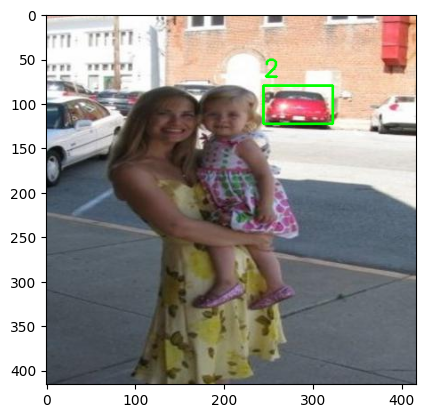

In [186]:
plt.imshow(image)

# BUG!!!
- Box coordinates are incorrect most likely due to the many transformations of the images